Name: Zheng Hanming

ID: 21225621

Module Code: RL

In [ ]:
!pip install gym==0.19.0
import time
from keras.optimizers import Adam
from tensorflow.keras.layers import Dense
import tensorflow as tf
import numpy as np
import gym
import pylab as pl
import matplotlib.pyplot as plt
import warnings
from collections import deque


%matplotlib inline
warnings.filterwarnings("ignore")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Task 1   (Complete by Sat, 25/Feb/23)
Implement tabular Sarsa OR Q-Learning for the problem outlined in Example 6.5 (Windy Grid World) OR Example 6.6 (Cliff Walking Grid World) in the Reinforcement Learning Sutton and Barto’s text on Reinforcement Learning, 2nd Edition (2018) (http://incompleteideas.net/book/the-book-2nd.html).
- **Clearly state references for this task at the start of the code section, and cite these references in comments.**

Post when completed, you are not required to comment on other submissions. But do have a look!

*Clearly state references for each of these task at the start of the respective code sections, and cite these references in comments.*

Time elapsed:  0.5165870189666748
[[ 0.  0.  0.  0.  0.  6.  7.  8.  9. 10.]
 [ 0.  0.  0.  0.  5.  0.  0.  0.  0. 11.]
 [ 0.  0.  0.  4.  0.  0.  0.  0.  0. 12.]
 [ 1.  2.  3.  0.  0.  0.  0. 18.  0. 13.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 14.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 17. 15.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 16.]]




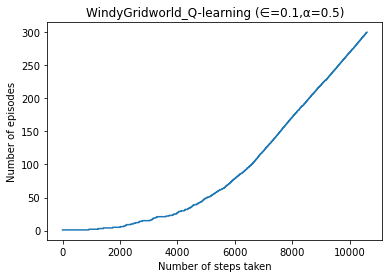

In [ ]:
# Problem: Example 6.5 (Windy GridWorld) | Solution: Q-Learning
# Reference: https://www.kaggle.com/code/kamal007/windy-grid-world-solution-using-sarsa-q-learning/notebook#2.-Define-GridWorld-Class

class WindyGridWorld():
    UP = 'UP'
    DOWN = 'DOWN'
    LEFT = 'LEFT'
    RIGHT = 'RIGHT'
    # initializes the grid of 7 rows and 10 columns in Example 6.5 Windy Gridworld
    row_count = 7
    col_count = 10
    # lvl1_wind: wind strength is 1, a move to this col will shift the position up by 1
    lvl_1_wind_col = [3, 4, 5, 8]
    # lvl2_wind: wind strength is 2, a move to this col will shift the position up by 2
    lvl_2_wind_col = [6, 7]
    # allowed actions in this problem
    actions_list = [UP, RIGHT, DOWN, LEFT]

    def __init__(self):
        super(WindyGridWorld, self).__init__()
        self.start = self.get_flatten_index((3, 0))
        self.goal = self.get_flatten_index((3, 7))

    def get_flatten_index(self, pos):
        # calculate the state using col and row of a position
        # state is the flattened index of the whole map
        # 1st row 1st col = 0; 2nd row 1st col = 10; 3rd row 1st col = 30
        # e.g. (3, 0) = 30 | (4, 3) = 42
        row, col = pos
        return col + self.col_count * row

    def get_pos_from_flatten_index(self, flatten_index):
        # calculate col and row from the state / flattened index
        # position e.g. (2,3) :: get_pos_from_flatten_index(get_flatten_index(position)) should be equal to position(2, 3)
        col = flatten_index % self.col_count
        row = (flatten_index - col) / self.col_count
        return int(row), int(col)

    def next_state(self, flatten_index, action):
        # get position from get_state
        row, col = self.get_pos_from_flatten_index(flatten_index)

        # determine the movement based on the supplied action
        del_x = 0
        del_y = 0
        if action == self.RIGHT:
            del_x = 1
        elif action == self.LEFT:
            del_x = -1
        elif action == self.UP:
            del_y = -1
        elif action == self.DOWN:
            del_y = 1
        else:
            # throw error when action is not allowed for that given state
            raise('Invalid action! Actions taken must be in: ', self.actions_list)

        # calculate the new col and position index using original position and the movement
        new_col = max(0, min(col + del_x, self.col_count - 1))
        new_row = max(0, min(row + del_y, self.row_count - 1))

        # adjust the position for movements into windy columns
        # max(0, x) means that the position cannot be shifted up because it is already at the top
        if new_col in self.lvl_1_wind_col:
            # lvl 1 wind col will shift position up by 1
            new_row = max(0, new_row - 1)
        if new_col in self.lvl_2_wind_col:
            # lvl 2 wind col will shift position up by 2
            new_row = max(0, new_row - 2)

        # return the new state and reward for the move
        return self.get_flatten_index((new_row, new_col))

    def is_goal_reached(self, state):
        # check if the goal is reached by checking if current position is equal to the final position
        # comparison is done using the state because each position will have a unique state
        return state == self.goal

    def reward_function(self, state_prime):
        # for each movement that does not reach the goal, the reward will be reduced by 1
        # the more steps it takes the lower the score it will be
        if state_prime == self.goal:
            return 0
        else:
            return -1

    def plot_trajectory(self, traj):
        # traj contains the list of steps(positions) from the beginning to the end
        # this function plots the path taken by the alrogithm
        world_map = np.zeros((self.row_count, self.col_count))
        for i, flatten_index in enumerate(traj):
            row, col = self.get_pos_from_flatten_index(flatten_index)
            world_map[row, col] = i + 1
        print(world_map)
        print("\n")


def gridWorld_QLearning(world, alpha, gamma=1, ep_max=300, eps=0.1):
    # create the q_table with all states and allowed actions for each states
    q_table = {}
    for flatten_index in range(world.row_count * world.col_count):
        q_table[flatten_index] = {}
        for act in world.actions_list:
            # initialize with 0 because the agent does not know anything about environment
            q_table[flatten_index][act] = 0

    def select_action_on_q_value(actions_for_given_pos):
        # select action with the highest q_value
        action_list_with_q_values = list(actions_for_given_pos.items())
        action_with_highest_q_value = sorted(
            action_list_with_q_values, key=lambda x: x[1])[-1]
        (action, q_value) = action_with_highest_q_value
        return action

    def epsGreedy(q_dict):
        # trade off between exploration & exploitation through probability
        # exploration: exploring the environment to find out information about it.
        #     exploration alone means the agent is not able to utilize existing experience
        # exploitation: exploiting the information that is already known about the environment.
        #     exploitation alone means the agent is not able find alternative paths with better score
        action_list = list(q_dict.keys())
        choice_count = len(action_list)
        chosen_action = select_action_on_q_value(q_dict)

        # eps controls how likely the agent is acting accoriding to past experience(q values)
        #   eps = 0: act purely based on q_values
        #   eps = 1: act randomly
        probability = []
        for act in action_list:
            if act == chosen_action:
                probability.append((eps * 1. / choice_count) + 1 - eps)
            else:
                probability.append(eps * 1. / choice_count)
        choice = np.random.choice(action_list, size=1, p=probability)
        return choice[0]

    ep_wrt_step = []
    trajectory = []
    # play the game ex_max times
    for ep in range(1, ep_max + 1):
        flatten_index = world.start
        trajectory = []
        while not world.is_goal_reached(flatten_index):
            # choose action using epsilon greedy strategy
            act = epsGreedy(q_table[flatten_index])
            # get next action and its reward after taking the action for current state
            s_prime = world.next_state(flatten_index, act)
            reward = world.reward_function(s_prime)

            # get the best action to take for next state
            act_prime = select_action_on_q_value(q_table[s_prime])
            # update q-value from experience of the game
            # q-value will converge to the optimal q-value over time
            q_table[flatten_index][act] += alpha * \
                (reward + gamma * q_table[s_prime]
                 [act_prime] - q_table[flatten_index][act])

            # store trajectory for each episode
            trajectory.append(flatten_index)

            # update current state after movement
            flatten_index = s_prime
            ep_wrt_step.append(ep)
        # store the lastest state after training the agent, this state is the goal of the problem
        trajectory.append(world.goal)
    return trajectory, ep_wrt_step


world = WindyGridWorld()
start_time = time.time()
trajectory, ep_wrt_step = gridWorld_QLearning(
    world, alpha=0.5, gamma=0.9, ep_max=300, eps=0.1)
print("Time elapsed: ", time.time() - start_time)
world.plot_trajectory(trajectory)
pl.figure(1)
pl.plot(ep_wrt_step)
plt.title('WindyGridworld_Q-learning (∈=0.1,α=0.5)', fontsize='large')
pl.xlabel("Number of steps taken")
pl.ylabel("Number of episodes")
pl.show()


### Task 2 (Complete by Sat, 04/03/23)
Implement a "vanilla" DQN for an Atari game using OpenAI Gym or other platform.

- Links
  - https://gymnasium.farama.org/environments/classic_control/cart_pole/
  - https://gymnasium.farama.org/environments/atari
  - https://github.com/openai/gym/wiki

**Clearly state references for this task at the start of the code sections, and cite these references in comments**.\
Clearly distinguish between 3rd party source and "new" code written by you.

**POST and RESPOND** by the suggested completion date

*Clearly state references for each of these task at the start of the respective code sections, and cite these references in comments.*

1. Spent a lot of time trying to get Atari Break to work on PC(failed)
2. Switch to use Colab
3. Complete the notebook to train Breakout
    - Crashed with 12gb RAM on Colab(Free)
    - Crashed with 85gb RAM on Colab(Pay As You Go) costing 90+ compute units
4. Migrate to JupyterLab
    - Server went down on 2023-03-02 while half way in training



Episode:     1 | Epsilon: 1.000 | Current Reward:  20 | Average Rewards:  20
Episode:     2 | Epsilon: 1.000 | Current Reward:  15 | Average Rewards:  17
Episode:     3 | Epsilon: 1.000 | Current Reward:  21 | Average Rewards:  18
Episode:     4 | Epsilon: 0.995 | Current Reward:  13 | Average Rewards:  17
Episode:     5 | Epsilon: 0.959 | Current Reward:  36 | Average Rewards:  21
Episode:     6 | Epsilon: 0.935 | Current Reward:  24 | Average Rewards:  21
Episode:     7 | Epsilon: 0.918 | Current Reward:  17 | Average Rewards:  20
Episode:     8 | Epsilon: 0.902 | Current Reward:  16 | Average Rewards:  20
Episode:     9 | Epsilon: 0.871 | Current Reward:  31 | Average Rewards:  21
Episode:    10 | Epsilon: 0.861 | Current Reward:  10 | Average Rewards:  20
Episode:    11 | Epsilon: 0.839 | Current Reward:  22 | Average Rewards:  20
Episode:    12 | Epsilon: 0.826 | Current Reward:  13 | Average Rewards:  20
Episode:    13 | Epsilon: 0.805 | Current Reward:  21 | Average Rewards:  20

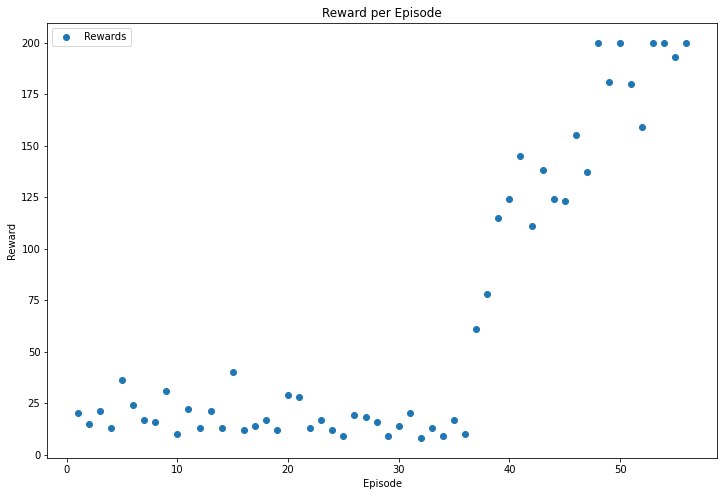

In [ ]:
# Problem: CartPole | Solution: DQN
# https://github.com/nicknochnack/TensorflowKeras-ReinforcementLearning/blob/master/Deep%20Reinforcement%20Learning.ipynb
# https://keras.io/examples/rl/deep_q_network_breakout/
# https://www.kaggle.com/code/danieldreher/vanilla-dqn-cartpole-tensorflow-2-3/notebook
# I initially started with Atari Break Out but it took too much RAM and time to train.
# Then I switch back to the CartPole as suggested by the annoucement.

class DecayingEpsilon:
    # OWN_CODE: added class to track and decay the epsilon which will be used for deciding the action to be taken
    def __init__(self, max_eps=1, min_eps=0.01, decay_rate=0.001):
        self.decay_rate = decay_rate
        self.max_eps = max_eps
        self.min_eps = min_eps
        self.epsilon = max_eps

    def get(self):
        return self.epsilon

    def decay(self):
        new_epsilon = self.epsilon - self.decay_rate
        self.epsilon = max(new_epsilon, self.min_eps)


class DQN(tf.keras.Model):
    def __init__(self, action_count):
      super(DQN, self).__init__()
      self.d1 = Dense(128, activation='relu')
      self.d2 = Dense(128, activation='relu')
      self.a = Dense(action_count, activation=None)

    def call(self, input_data):
      x = self.d1(input_data)
      x = self.d2(x)
      x = self.a(x)
      return x


class ReplayBuffer():
    def __init__(self, input_shape, buffer_size=50000):
        # create replay experience buffer using deque with a fixed size
        self.buffer_size = buffer_size
        self.state_history = deque(maxlen=buffer_size)
        self.action_history = deque(maxlen=buffer_size)
        self.reward_history = deque(maxlen=buffer_size)
        self.next_state_history = deque(maxlen=buffer_size)
        self.done_history = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        # add states, actions and other details into buffer
        self.state_history.append(state)
        self.action_history.append(action)
        self.reward_history.append(reward)
        self.next_state_history.append(next_state)
        self.done_history.append(1 - int(done))

    def sample(self, batch_size=64):
        # generate a random sample from the replay memory/buffer to be used for calculating and updating q learning model
        batch = np.random.choice(
            len(self.done_history), batch_size, replace=False)
        sample_states = np.array(self.state_history)[batch]
        sample_actions = np.array(self.action_history)[batch]
        sample_rewards = np.array(self.reward_history)[batch]
        sample_next_states = np.array(self.next_state_history)[batch]
        sample_dones = np.array(self.done_history)[batch]
        return sample_states, sample_actions, sample_rewards, sample_next_states, sample_dones


class DQNAgent():
    def __init__(self, replay_buffer, action_count, lr=0.001):
          # initialize DQN agent with model and target model
          self.action_count = action_count
          self.epsilon_schedule = DecayingEpsilon()
          self.replay_buffer = replay_buffer
          opt = tf.keras.optimizers.Adam(learning_rate=lr)
          self.model = DQN(action_count)
          self.target_model = DQN(action_count)
          self.model.compile(loss='mse', optimizer=opt)
          self.target_model.compile(loss='mse', optimizer=opt)

    def __get_action__(self, state):
        # get action using epsilon greedy policy
        if np.random.rand() <= self.epsilon_schedule.get():
            # choose a random action is a random number is below epsilon
            # random action will be used a lot in the beginning when the epsilon is high
            # this means exploration will be heavily used in the beginning
            return np.random.choice([i for i in range(self.action_count)])
        else:
            # when a random number is above expsilon, action will be generated by the model using past experience
            # this is the exploitation part of the algorithm
            # exploitation will be used heavily in the end as epsilon decreases
            actions = self.model(np.array([state]))
            action = np.argmax(actions)
            return action

    def __plot_history__(self, scores):
        # plot the scatter plots for rewards
        episodes = list(range(1, len(scores) + 1))
        plt.figure(figsize=(12, 8))
        plt.scatter(episodes, scores, label='Rewards') #
        plt.title('Reward per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.show()

    def train(self, batch_size, gamma=0.99):
        # training of the model

        # generate sample sates and actions
        sample_states, sample_actions, sample_rewards, sample_next_states, sample_dones = self.replay_buffer.sample(
            batch_size)
        # get the q values using curent states and model
        q_values = self.model.predict(sample_states, verbose=0)
        # get the q values using sample next_states and target model
        q_values_next = self.target_model.predict(
            sample_next_states, verbose=0)
        # choose the action using sample next states and model
        max_action = np.argmax(self.model.predict(
            sample_next_states, verbose=0), axis=1)
        batch_index = np.arange(batch_size, dtype=np.int32)
        q_target = np.copy(q_values)
        # update q values
        q_target[batch_index, sample_actions] = sample_rewards + \
            gamma * q_values_next[batch_index, max_action] * sample_dones
        # traing the model using the new q values
        self.model.train_on_batch(sample_states, q_target)
        # decay epsilon after each training
        self.epsilon_schedule.decay()

    def save_model(self):
        self.model.save_weights("model.h5")
        self.target_model.save_weights("target_model.h5")

    def load_model(self):
        self.model.load_weights("model.h5")
        self.target_model.load_weights("model.h5")

    def fit(self, env, max_episodes, batch_size=64, update_freq=100):
        # main training algorithm

        # all_rewards keeps track of the total rewards for all episodes combined
        all_rewards = []
        # frame_count is the frame of the game, if a episode lasts 20 frames then this will increase by 20 after episode is done
        frame_count = 1
        for s in range(1, max_episodes + 1):
          done = False
          # resets the game state
          state = env.reset()
          # total reward is the total rewards for each episode
          total_reward = 0

          while not done:
              # choose action
              action = self.__get_action__(state)
              # take actio and get the next state and reward
              # done is also returned and it will be used to determine if the current epsiode is completed: Success OR Failure
              next_state, reward, done, _ = env.step(action)
              # add above into replay buffer for sampling later
              self.replay_buffer.add(state, action, reward, next_state, done)

              # if the agent has play more frames than the batch size, then training starts
              # this is because training require the replay buffer to have at least batch_size number of past experiences
              if frame_count > batch_size:
                  self.train(batch_size)

              # update the target model periodically
              if frame_count % update_freq == 0:
                  self.target_model.set_weights(self.model.get_weights())

              # set state with the new state after movement
              state = next_state
              # increase total reward and frame count
              total_reward += reward
              frame_count += 1

          # adds total reward of current episode to all rewards tracker
          all_rewards.append(total_reward)
          print(f'Episode: {s:5}',
                f'| Epsilon: {self.epsilon_schedule.get():.3f}',
                f'| Current Reward: {int(total_reward):3}',
                f'| Average Rewards: {int(np.mean(all_rewards[-10:])):3}'
                )

          # finishing all training with the average rewards for the past 10 episodes reaches 185 frames/rewards
          if np.mean(all_rewards[-10:]) >= 185:
              break

        self.__plot_history__(all_rewards)
        self.save_model()


max_episodes = 400
env = gym.make('CartPole-v0')
replay_buffer = ReplayBuffer(env.observation_space.shape)
agent = DQNAgent(replay_buffer, env.action_space.n)

agent.fit(env, max_episodes)


### Task 3 and 4 (Complete by Sunday, 12/03/23)
This task is not to be uploaded to GitHub but directly to Sulis.

**Task 3**: reflect on the critique offered in the forum for task 1+2, and edit the code to incorporate suggestion(s) offered where reasonable.
- Clearly indicate where you have done this.
- Incorporate recent research findings such as Dueling DQNs

**Task 4**: analyse the impact of varying hyperparameters.\
The metrics reported for tasks 3 and 4 are left at your discretion\
Use the same Jupyter notebook as that used in Tasks 1 and 2\
DO NOT MODIFY the implementation for Tasks 1 and 2 --> Task 3 is a new section!

*Clearly state references for each of these task at the start of the respective code sections, and cite these references in comments.*

#### Update Task 1 Work - Problem: Example 6.5 (Windy GridWorld) | Solution: Q-Learning

Chosen Path: Final Steps(18) | Alpha(1) | Total Score(-16704)
[[ 0.  0.  0.  0.  0.  6.  7.  8.  9. 10.]
 [ 0.  0.  0.  0.  5.  0.  0.  0.  0. 11.]
 [ 0.  0.  0.  4.  0.  0.  0.  0.  0. 12.]
 [ 1.  2.  3.  0.  0.  0.  0. 18.  0. 13.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 14.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 17. 15.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 16.]]


From the plots, it is easy to observe that with a higher learning rate, the agent reach to ideal path faster than with lower learning rates.
High learning rate works fine for simple problems and not complex problems as the agent tends to find local optimum.


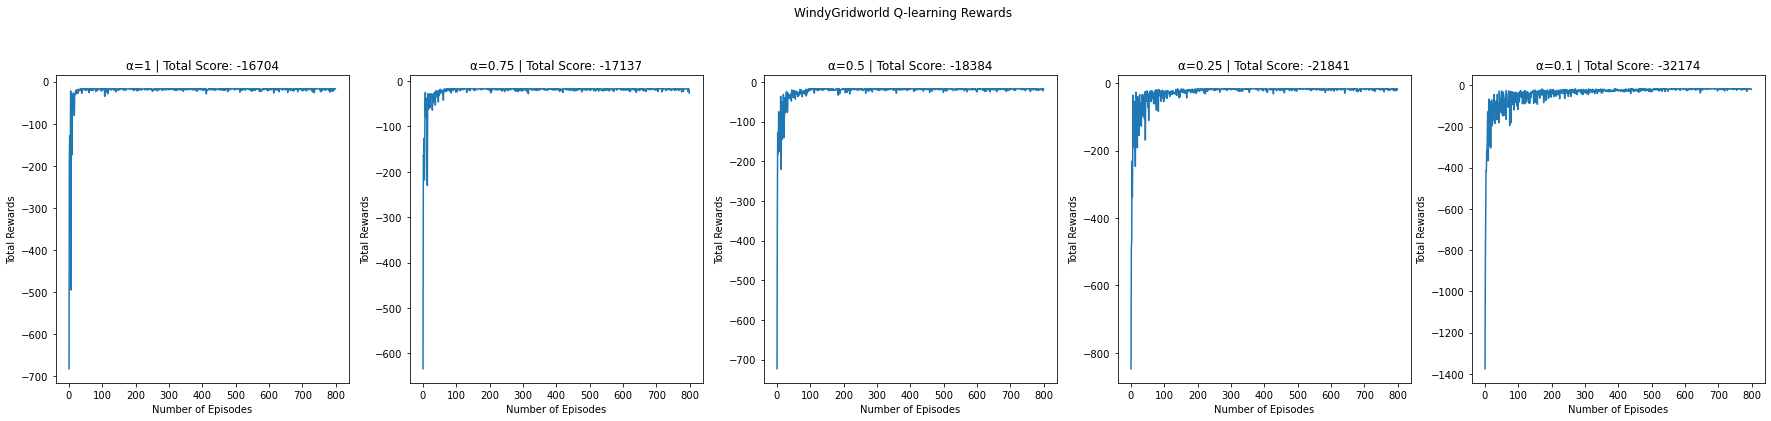

In [ ]:
# Problem: Example 6.5 (Windy GridWorld) | Solution: Q-Learning
# Reference: https://www.kaggle.com/code/kamal007/windy-grid-world-solution-using-sarsa-q-learning/notebook#2.-Define-GridWorld-Class

# https://ai.stackexchange.com/questions/12268/in-q-learning-shouldnt-the-learning-rate-change-dynamically-during-the-learnin

class WindyGridWorld():
    __UP__ = 'UP'
    __DOWN__ = 'DOWN'
    __LEFT__ = 'LEFT'
    __RIGHT__ = 'RIGHT'
    # initializes the grid of 7 rows and 10 columns in Example 6.5 Windy Gridworld
    __row_count__ = 7
    __col_count__ = 10
    # indicates the columns that have wind effects
    # lvl1_wind: wind strength is 1, a move to this col will shift the position up by 1
    __lvl_1_wind_col__ = [3, 4, 5, 8]
    # lvl2_wind: wind strength is 2, a move to this col will shift the position up by 2
    __lvl_2_wind_col__ = [6, 7]

    def __init__(self):
        super(WindyGridWorld, self).__init__()
        self.__start__ = self.__get_state__((3, 0))
        self.__goal__ = self.__get_state__((3, 7))

    def __get_state__(self, pos):
        row, col = pos
        # calculate the state using col and row of a position
        # state is the flattened index of the whole map
        # 1st row 1st col = 0; 2nd row 1st col = 10; 3rd row 1st col = 30
        # e.g. (3, 0) = 30 | (4, 3) = 42
        return col + self.__col_count__ * row

    def __get_pos_from_state__(self, state):
        # calculate col and row from the state
        # position e.g. (2,3) :: __get_pos_from_state__(__get_state__(position)) should be equal to position(2, 3)
        col = state % self.__col_count__
        row = (state - col) / self.__col_count__
        return int(row), int(col)

    def __get_allowed_action__(self, row, col):
        # get allowed actions for given position
        # e.g. when agent is at the top left of the map, it cannot go up or left because that will go out of the map
        disabled_actions = []
        if col == 0:
            # agent cannot go left on the left-most col
            disabled_actions.append(self.__LEFT__)
        if col == (self.__col_count__ - 1):
            # agent cannot go right on the right-most col
            disabled_actions.append(self.__RIGHT__)
        if row == 0:
            # agent cannot go up on the top row
            disabled_actions.append(self.__UP__)
        if row == (self.__row_count__ - 1):
            # agent cannot go down on the bottom row
            disabled_actions.append(self.__DOWN__)
        allowed_actions = [self.__UP__, self.__RIGHT__,
                           self.__DOWN__, self.__LEFT__]
        for act in disabled_actions:
            allowed_actions.remove(act)
        return allowed_actions

    def get_start_position(self):
        return self.__start__

    def calc_reward(self, state_prime):
        # for each movement that does not reach the goal, the reward will be reduced by 1
        # the more steps it takes the lower the score it will be
        if state_prime == self.__goal__:
            return 0
        else:
            return -1

    def next_state(self, state, action):
        # get position from get_state
        row, col = self.__get_pos_from_state__(state)

        # throw error when action is not allowed for that given state
        allowed_actions = self.__get_allowed_action__(row, col)
        if (action not in allowed_actions):
            raise('Invalid Action! Allowed: ', allowed_actions)

        # determine the movement based on the supplied action
        del_x = 0
        del_y = 0
        if action == self.__RIGHT__:
            del_x = 1
        elif action == self.__LEFT__:
            del_x = -1
        elif action == self.__UP__:
            del_y = -1
        elif action == self.__DOWN__:
            del_y = 1

        # calculate the new col and position index using original position and the movement
        new_col = max(0, min(col + del_x, self.__col_count__ - 1))
        new_row = max(0, min(row + del_y, self.__row_count__ - 1))

        # adjust the position for movements into windy columns
        # max(0, x) means that the position cannot be shifted up because it is already at the top
        if new_col in self.__lvl_1_wind_col__:
            # lvl 1 wind col will shift position up by 1
            new_row = max(0, new_row - 1)
        if new_col in self.__lvl_2_wind_col__:
            # lvl 2 wind col will shift position up by 2
            new_row = max(0, new_row - 2)

        # return the new state and reward for the move
        new_state = self.__get_state__((new_row, new_col))
        return new_state, self.calc_reward(new_state)

    def is_goal_reached(self, state):
        # check if the goal is reached by checking if current position is equal to the final position
        # comparison is done using the state because each position will have a unique state
        return state == self.__goal__

    def plot_trajectory(self, traj):
        # traj contains the list of steps(positions) from the beginning to the end
        # this function plots the path taken by the alrogithm
        world_map = np.zeros((self.__row_count__, self.__col_count__))
        for i, state in enumerate(traj):
            row, col = self.__get_pos_from_state__(state)
            # for each step, the step count is entered into that position
            world_map[row, col] = i + 1
        print(world_map)
        print("\n")

    def get_q_table(self):
        # the problem has the best knowledge about the limitations and hence the allowed actions for each state
        # below returns the q_table with all states and allowed actions for each state
        q_table = {}
        for col in range(self.__col_count__):
            for row in range(self.__row_count__):
                allowed_actions = self.__get_allowed_action__(row, col)
                state = self.__get_state__((row, col))
                q_table[state] = {}
                for act in allowed_actions:
                    # initialize all allowed actions be 0 for each state
                    # 0 assumes no prior knowledge is knowledge by the agent at the beginning
                    q_table[state][act] = 0
        return q_table


class QLearningOptimizer():
    # This optimizer can be used to do RL on any problem like the Windy Grid world.
    # The problem must be able to be mapped into a q_table where there is a list of states with actions for each state
    # The problem must provide the following methods for this optimizer to work
    #   get_q_table: this method returns the q_table with all states and actions attached to each state
    #   get_start_position: this method returns the starting position with coordinates
    #   is_goal_reached: this method returns boolean indicating if the goal has been reached
    #   next_state: this method returns the next state using current state and action to be performed
    #               the reward is also provided after moving to this state
    #   calc_reward: this method returns the reward for a given state
    # This optimier is problem agnostic as long as above methods are provided by the problem
    __eps__ = 0

    def __init__(self, problem):
        self.__q_table__ = problem.get_q_table()
        self.__problem__ = problem

    def __greedy_act__(self, actions_for_given_pos):
        # select action with the highest q_value
        action_list_with_q_values = list(actions_for_given_pos.items())
        action_with_highest_q_value = sorted(
            action_list_with_q_values, key=lambda x: x[1])[-1]
        (action, q_value) = action_with_highest_q_value
        return action

    def __eps_greedy_act__(self, q_dict):
        # trade off between exploration & exploitation through probability
        # exploration: exploring the environment to find out information about it.
        #     exploration alone means the agent is not able to utilize existing experience
        # exploitation: exploiting the information that is already known about the environment.
        #     exploitation alone means the agent is not able find alternative paths with better score
        action_list = list(q_dict.keys())
        chosen_action = self.__greedy_act__(q_dict)

        # eps controls how likely the agent is acting accoriding to past experience(q values)
        #   eps = 0: act purely based on q_values
        #   eps = 1: act randomly
        # default probability that the agent will choose for each action
        random_prob = self.__eps__ / len(action_list)
        # probability for preferred action(action is same as greedy action[with highest q value])
        preferred_prob = random_prob + 1 - self.__eps__

        # below calculates the probabilities for each actions allowed
        # if action is not same as greedy action, it will have a lower probability of being selected
        # if action is same as greedy action, it will have a higher probability of being selected
        probabilities = [preferred_prob if act ==
                         chosen_action else random_prob for act in action_list]
        # choose an action using the above probabilities
        choice = np.random.choice(action_list, size=1, p=probabilities)
        return choice[0]

    def fit(self, alpha, gamma=1, ep_max=300, eps=0.1):
        self.__eps__ = eps
        rewards_per_episode = []
        trajectory = []
        # play the game ex_max times
        for ep in range(1, ep_max + 1):
            current_state = self.__problem__.get_start_position()
            trajectory = []
            while not self.__problem__.is_goal_reached(current_state):
                # choose action using epsilon greedy strategy
                current_state_best_act = self.__eps_greedy_act__(
                    self.__q_table__[current_state])
                # get next action and its reward after taking the action for current state
                next_state, reward = self.__problem__.next_state(
                    current_state, current_state_best_act)

                # get the best action to take for next state
                next_state_best_act = self.__greedy_act__(
                    self.__q_table__[next_state])

                # update q-value from experience of the game
                # this updated q-value will be used in the next iteration
                # q-value will converge to the optimal q-value over time
                current_q_val = self.__q_table__[
                    current_state][current_state_best_act]
                next_q_val = self.__q_table__[next_state][next_state_best_act]
                # alpha determines how fast the agent move towards finding the optimal policy
                # with high alpha, q values are updated in bigger steps
                self.__q_table__[current_state][current_state_best_act] += alpha * \
                    (reward + gamma * next_q_val - current_q_val)

                # store trajectory for each episode
                trajectory.append(current_state)

                # update current state after movement
                current_state = next_state
            # store the lastest state after training the agent, this state is the goal of the problem
            trajectory.append(current_state)
            # for each episode, store the total rewards for the run, the lower the reward the longer it takes to reach the goal
            rewards_per_episode.append(
                sum([self.__problem__.calc_reward(state) for state in trajectory]))
        return trajectory, rewards_per_episode


# store the parameters as variables
alpha_list = [0.1, 0.25, 0.5, 0.75, 1]
max_episodes = 800
eps = 0.05
gamma = 1
problem = WindyGridWorld()

# train the RL model with different learning rates and store the results in the training_results list
training_results = []
for alpha in alpha_list:
  optimizer = QLearningOptimizer(problem)
  trajectory, rewards_per_eps = optimizer.fit(
      alpha=alpha, gamma=gamma, ep_max=max_episodes, eps=eps)
  training_results.append((trajectory, rewards_per_eps, alpha))

# initialize subplots for plotting of rewards per alpha
fig, axs = plt.subplots(1, len(alpha_list), figsize=(5 * len(alpha_list), 6))
fig.suptitle('WindyGridworld Q-learning Rewards')
fig.tight_layout(pad=(3))

# initialize dict for chosen model info
chosen = {'total_score': 0, 'trajectory': [], 'alpha': 0}

# the sort below ensures alpha run with less training steps is at the beginning
training_results = sorted(training_results, key=lambda x: sum(x[1]), reverse=True)
for i, (trajectory, rewards_per_eps, alpha) in enumerate(training_results):
    # plot the rewards into different subplots
    axs[i].plot(rewards_per_eps)
    axs[i].set_title(f'α={alpha} | Total Score: {sum(rewards_per_eps)}')
    axs[i].set_ylabel("Total Rewards")
    axs[i].set_xlabel("Number of Episodes")

    # choose the model based on the shortest steps to goal
    # note: because of the sort above, the chosen result prioritize to choose results with less total steps taken
    if len(chosen['trajectory']) == 0 or len(trajectory) < len(chosen['trajectory']):
        chosen = {
            'total_score': sum(rewards_per_eps),
            'trajectory': trajectory,
            'alpha': alpha
        }

print(f'Chosen Path: Final Steps({len(chosen["trajectory"])}) | Alpha({chosen["alpha"]}) | Total Score({chosen["total_score"]})')
problem.plot_trajectory(chosen['trajectory'])
print('From the plots, it is easy to observe that with a higher learning rate, the agent reach to ideal path faster than with lower learning rates.')
print('High learning rate works fine for simple problems and not complex problems as the agent tends to find local optimum.')


#### Update Task 2 Work - Problem: OpenAI CartPole | Solution: Dueling DQN

Training Start: Alpha 0.001 | Dueling False
Episode:     5 | Epsilon(Latest): 0.869 | Epsilon(Avg): 0.875 | Current Reward:  12 | Average Rewards:  39
Episode:    10 | Epsilon(Latest): 0.753 | Epsilon(Avg): 0.759 | Current Reward:  11 | Average Rewards:  31
Episode:    15 | Epsilon(Latest): 0.644 | Epsilon(Avg): 0.650 | Current Reward:  12 | Average Rewards:  22
Episode:    20 | Epsilon(Latest): 0.473 | Epsilon(Avg): 0.497 | Current Reward:  47 | Average Rewards:  28
Episode:    25 | Epsilon(Latest): 0.010 | Epsilon(Avg): 0.053 | Current Reward: 200 | Average Rewards:  70
Episode:    30 | Epsilon(Latest): 0.010 | Epsilon(Avg): 0.010 | Current Reward: 176 | Average Rewards: 134
Episode:    35 | Epsilon(Latest): 0.010 | Epsilon(Avg): 0.010 | Current Reward: 132 | Average Rewards: 171
Episode:    40 | Epsilon(Latest): 0.010 | Epsilon(Avg): 0.010 | Current Reward: 182 | Average Rewards: 180
Episode:    45 | Epsilon(Latest): 0.010 | Epsilon(Avg): 0.010 | Current Reward: 177 | Average Reward

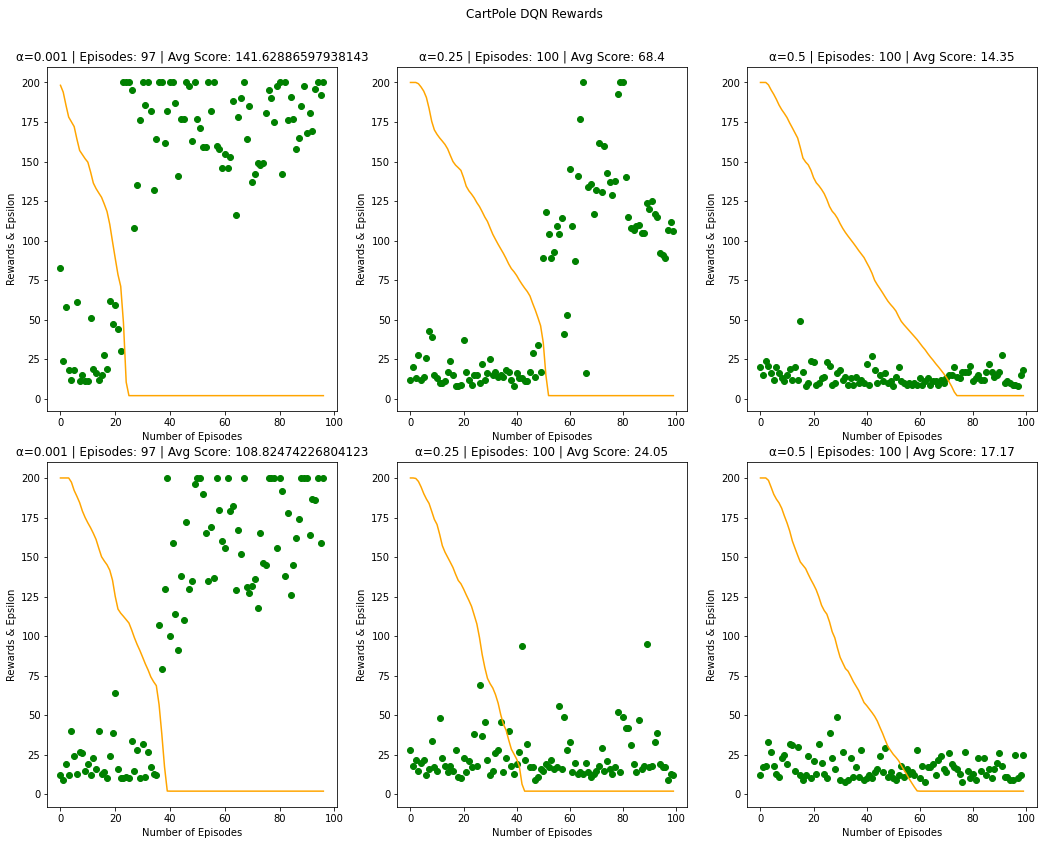

In [ ]:
# Problem: CartPole | Solution: DQN
# https://github.com/nicknochnack/TensorflowKeras-ReinforcementLearning/blob/master/Deep%20Reinforcement%20Learning.ipynb
# https://keras.io/examples/rl/deep_q_network_breakout/
# https://www.kaggle.com/code/danieldreher/vanilla-dqn-cartpole-tensorflow-2-3/notebook
# I initially started with Atari Break Out but it took too much RAM and time to train.
# Then I switch back to the CartPole as suggested by the annoucement.

class DecayingEpsilon:
    # OWN_CODE: added class to track and decay the epsilon which will be used for deciding the action to be taken
    def __init__(self, max_eps=1, min_eps=0.01, decay_rate=0.001):
        self.decay_rate = decay_rate
        self.max_eps = max_eps
        self.min_eps = min_eps
        self.epsilon = max_eps

    def get(self):
        return self.epsilon

    def decay(self):
        new_epsilon = self.epsilon - self.decay_rate
        self.epsilon = max(new_epsilon, self.min_eps)


class DQN(tf.keras.Model):
    def __init__(self, action_count):
      super(DQN, self).__init__()
      self.d1 = Dense(128, activation='relu')
      self.d2 = Dense(128, activation='relu')
      self.a = Dense(action_count, activation=None)

    def call(self, input_data):
      x = self.d1(input_data)
      x = self.d2(x)
      x = self.a(x)
      return x

class DDDQN(tf.keras.Model):
    def __init__(self, action_count):
      super(DDDQN, self).__init__()
      self.d1 = Dense(128, activation='relu')
      self.d2 = Dense(128, activation='relu')
      self.v = Dense(1, activation=None)
      self.a = Dense(action_count, activation=None)

    def call(self, input_data):
      x = self.d1(input_data)
      x = self.d2(x)
      v = self.v(x)
      a = self.a(x)
      Q = v +(a -tf.math.reduce_mean(a, axis=1, keepdims=True))
      return Q

    def advantage(self, state):
      x = self.d1(state)
      x = self.d2(x)
      a = self.a(x)
      return a


class ReplayBuffer():
    def __init__(self, input_shape, buffer_size=50000):
        # create replay experience buffer using deque with a fixed size
        self.buffer_size = buffer_size
        self.state_history = deque(maxlen=buffer_size)
        self.action_history = deque(maxlen=buffer_size)
        self.reward_history = deque(maxlen=buffer_size)
        self.next_state_history = deque(maxlen=buffer_size)
        self.done_history = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        # add states, actions and other details into buffer
        self.state_history.append(state)
        self.action_history.append(action)
        self.reward_history.append(reward)
        self.next_state_history.append(next_state)
        self.done_history.append(1 - int(done))

    def sample(self, batch_size=64):
        # generate a random sample from the replay memory/buffer to be used for calculating and updating q learning model
        batch = np.random.choice(
            len(self.done_history), batch_size, replace=False)
        sample_states = np.array(self.state_history)[batch]
        sample_actions = np.array(self.action_history)[batch]
        sample_rewards = np.array(self.reward_history)[batch]
        sample_next_states = np.array(self.next_state_history)[batch]
        sample_dones = np.array(self.done_history)[batch]
        return sample_states, sample_actions, sample_rewards, sample_next_states, sample_dones


class DQNAgent():
    def __init__(self, replay_buffer, action_count, learning_rate=0.001, dueling=False):
          # initialize DQN agent with model and target model
          self.action_count = action_count
          self.epsilon_schedule = DecayingEpsilon()
          self.dueling = dueling
          self.replay_buffer = replay_buffer
          opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
          self.model = DQN(action_count) if dueling == False else DDDQN(action_count)
          self.target_model = DQN(action_count) if dueling == False else DDDQN(action_count)
          self.model.compile(loss='mse', optimizer=opt)
          self.target_model.compile(loss='mse', optimizer=opt)

    def __get_action__(self, state):
        # get action using epsilon greedy policy
        if np.random.rand() <= self.epsilon_schedule.get():
            # choose a random action is a random number is below epsilon
            # random action will be used a lot in the beginning when the epsilon is high
            # this means exploration will be heavily used in the beginning
            return np.random.choice([i for i in range(self.action_count)])
        else:
            # when a random number is above expsilon, action will be generated by the model using past experience
            # this is the exploitation part of the algorithm
            # exploitation will be used heavily in the end as epsilon decreases
            actions = self.model(np.array([state])) if self.dueling == False else self.model.advantage(np.array([state]))
            action = np.argmax(actions)
            return action

    def __plot_history__(self, scores, epsilons):
        # plot the scatter plots for rewards
        episodes = list(range(1, len(scores) + 1))
        plt.figure(figsize=(12, 8))
        plt.scatter(episodes, scores, label='Rewards')
        plt.plot(epsilons, label='Epsilon')
        plt.title('Reward per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.show()

    def __train__(self, batch_size, gamma=0.99):
        # training of the model

        # generate sample sates and actions
        sample_states, sample_actions, sample_rewards, sample_next_states, sample_dones = self.replay_buffer.sample(
            batch_size)
        # get the q values using curent states and model
        q_values = self.model.predict(sample_states, verbose=0)
        # get the q values using sample next_states and target model
        q_values_next = self.target_model.predict(
            sample_next_states, verbose=0)
        # choose the action using sample next states and model
        max_action = np.argmax(self.model.predict(
            sample_next_states, verbose=0), axis=1)
        batch_index = np.arange(batch_size, dtype=np.int32)
        q_target = np.copy(q_values)
        # update q values
        q_target[batch_index, sample_actions] = sample_rewards + \
            gamma * q_values_next[batch_index, max_action] * sample_dones
        # traing the model using the new q values
        self.model.train_on_batch(sample_states, q_target)
        # decay epsilon after each training
        self.epsilon_schedule.decay()

    def save_model(self):
        self.model.save_weights("model.h5")
        self.target_model.save_weights("target_model.h5")

    def load_model(self):
        self.model.load_weights("model.h5")
        self.target_model.load_weights("model.h5")

    def fit(self, env, max_episodes, batch_size=64, update_freq=100, completion_score=185, plot=True, logging_freq=1):
        # main training algorithm

        # all_rewards keeps track of the total rewards and epsilons for all episodes
        all_rewards = []
        all_epsilons = []
        # frame_count is the frame of the game, if a episode lasts 20 frames then this will increase by 20 after episode is done
        frame_count = 1
        for episode in range(1, max_episodes + 1):
          done = False
          # resets the game state
          state = env.reset()
          # total reward is the total rewards for each episode
          total_reward_per_episode = 0
          epsilons_per_episode = []

          while not done:
              # choose action
              action = self.__get_action__(state)
              # take actio and get the next state and reward
              # done is also returned and it will be used to determine if the current epsiode is completed: Success OR Failure
              next_state, reward, done, _ = env.step(action)
              # add above into replay buffer for sampling later
              self.replay_buffer.add(state, action, reward, next_state, done)

              # if the agent has play more frames than the batch size, then training starts
              # this is because training require the replay buffer to have at least batch_size number of past experiences
              if frame_count > batch_size:
                  epsilons_per_episode.append(self.epsilon_schedule.get())
                  self.__train__(batch_size)

              # update the target model periodically
              if frame_count % update_freq == 0:
                  self.target_model.set_weights(self.model.get_weights())

              # set state with the new state after movement
              state = next_state
              # increase total reward and frame count
              total_reward_per_episode += reward
              frame_count += 1

          # adds total reward & avg epsilon of current episode to all rewards tracker
          all_rewards.append(total_reward_per_episode)
          all_epsilons.append(np.mean(epsilons_per_episode) if len(epsilons_per_episode) > 0 else 1)

          if episode % logging_freq == 0:
              print(f'Episode: {episode:5}',
                    f'| Epsilon(Latest): {self.epsilon_schedule.get():.3f}',
                    f'| Epsilon(Avg): {all_epsilons[-1]:.3f}',
                    f'| Current Reward: {int(total_reward_per_episode):3}',
                    f'| Average Rewards: {int(np.mean(all_rewards[-10:])):3}'
                    )

          # finishing all training with the average rewards for the past 10 episodes reaches 185 frames/rewards
          if np.mean(all_rewards[-10:]) >= completion_score:
              break
        
        print(f'Training Completed: Episode {len(all_rewards)} Avg(Last 10) {int(np.mean(all_rewards[-10:])):3}')
        if plot:
          self.__plot_history__(all_rewards, np.multiply(all_epsilons, 200))
        # self.save_model()
        return all_rewards, all_epsilons


alpha_list = [0.001, 0.25, 0.5]
dueling_list = [False, True]
max_episodes = 100
completion_score = 185
GAME = 'CartPole-v0'
env = gym.make(GAME)


# initialize subplots for plotting of rewards per alpha and type of modelling
fig, axs = plt.subplots(len(dueling_list), len(alpha_list), figsize=(5 * len(alpha_list), 6 * len(dueling_list)))
# 1st row: normal DQN
# 2nd row: dueling DQN
fig.suptitle('CartPole DQN Rewards')
fig.tight_layout(pad=(3))

# train the RL model with different learning rates and plot the results
#   orange line is the decaying epsilon
#   blue scatter is the scores for different episodes
for i, dueling in enumerate(dueling_list):
    for j, alpha in enumerate(alpha_list):
        print(f'Training Start: Alpha {alpha} | Dueling {dueling}')
        replay_buffer = ReplayBuffer(env.observation_space.shape)
        agent = DQNAgent(replay_buffer, env.action_space.n, dueling=dueling, learning_rate=alpha)
        rewards, epsilons = agent.fit(env, max_episodes, plot=False, completion_score=completion_score, logging_freq=5)

        episodes = list(range(len(rewards)))
        axs[i, j].scatter(episodes, rewards, label='Rewards', c='green')
        axs[i, j].plot(np.multiply(epsilons, 200), label='Epsilon', c='orange')
        axs[i, j].set_title(f'α={alpha} | Episodes: {len(episodes)} | Avg Score: {np.mean(rewards)}')
        axs[i, j].set_ylabel("Rewards & Epsilon")
        axs[i, j].set_xlabel("Number of Episodes")

        del replay_buffer
        del agent
        del rewards
        del epsilons

# we can observe that unlike the windy grid world problem, higher learning rate in this case does not perform better than lower learning rate
# this is because this problem is more complex than the grid world problem
#   higher learning rate causes the model to find local optima instead of correct model

### Reflection

I have updated my code according to the comments to add clearer graphs to illustrate the training performance.

From this etivity, it can be observed that the learning rate plays an important role in how fast or if the model finds the global optima.
  1. Simple problems tend to benefit from higher learning rate as finding global optima is easy and high learning rate improves training time.
  2. Complex problems do not benefit from higher learning rate as it causes the model to find local optima.

Task 1 Updated:
- We can see that with higher learning rate, the model takes a lot less time to generate the correct model

Task 2 Updated:
- We can see that the with higher learning rate, it takes longer for the model to see improvements in accuracy and sometimes, higher learning rate might cause the performance to not improve at all.
- With learning rate being 0.001, the model starts to perform really well after epsilon drops to 0.01, meaning the model to exploit past experience instead of simply exploring around.

## **Notes**

I would recommend logging the average reward for the policy every couple of episodes to show the training taking place.

For hyperparameters, I would recommend the learning rate. Adding a dropout layer, and model dimensions, (Bigger isn't better, but if the model makes more sense it should get more marks)

Marks will be deducted if mistakes are made, non-optimal policy, not sampling randomly, incorrect value function

The perfect notebook or script should be annotated to show the different moving parts, and have robust flexible code that is legible and explained look into RL in Practice video for more information